In [1]:
using PyPlot
using PyCall
np=pyimport("numpy")
eV = 27.2114; #Hartree to eV conversion
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 15
rcParams["legend.fontsize"] = "small"
rcParams["axes.labelsize"] = "xx-large"
rcParams["axes.titlesize"] = "xx-large"
rcParams["xtick.labelsize"] = "xx-large"
rcParams["ytick.labelsize"] = "xx-large"
rcParams["font.sans-serif"] = "Arial"
rcParams["font.family"] = "sans-serif"
rcParams["figure.figsize"] = (6, 6);

In [2]:
dir_nohybrid = string(pwd(), "/nohybrid");

In [291]:
#=#Loop over all simulations and store the band indices and oscillator strengths corresponding to the 
#relevant green and red transitions. 

AllValidPairsGreen = Vector{Tuple{String, Vector{Tuple{Integer, Integer, Float64}}}}()
# Vector of tuples of the form: (ID, (lowerband, upperband, oscillator strength))

AllValidPairsRed = Vector{Tuple{String, Vector{Tuple{Integer, Integer, Float64}}}}()
# Vector of tuples of the form: (ID, (lowerband, upperband, oscillator strength))

eigenvalsup = Float64[]
eigenvalsdn= Float64[]

momenta = ComplexF64[] #Note that the momentum matrix elements are complex though we only need their absolute values 
#in the end since we have no phase interfering terms. 
transitioneigenvals = Float64[]

for (i, j) in Tuple.(CartesianIndices(rand(4, 5)))
    id="$(i)$(j)"
    μ=0 

    try #The try catch block exists in case there are files that don't exist or we decided to disregard and got rid of 
        for l in readlines("$dir_nohybrid/STH2$(id).eigStats")
            if VERSION.minor >= 5  
                contains(l, "mu" ) || continue ;
            elseif VERSION.minor < 5
                occursin("mu", l) || continue ;
            end
            μ = parse(Float64, l[6:end]);
        end
        
        eigenvalsup = np.fromfile("$dir_nohybrid/STH2$(id).eigenvals")[1:48]*eV
        eigenvalsdn = np.fromfile("$dir_nohybrid/STH2$(id).eigenvals")[49:96]*eV
        up = eigenvalsup[28] > μ*eV
        down = eigenvalsdn[28] > μ*eV
        (up && down) && error("Something Went Wrong")
        transitioneigenvals = up ? eigenvalsup : eigenvalsdn
        momenta = np.reshape(abs.(np.fromfile("$dir_nohybrid/STH2$(id).momenta", dtype=np.complex )), (2, 3, 48, 48));
    catch
        continue
    end
    (permutedims(momenta, (1, 2, 4, 3)) ≈ conj(momenta)) || error("Momenta Do Not Satisfy Hermiticity Condition")
    ValidPairsUpGreen = Vector{Tuple{Integer, Integer, Float64}}() 
    for (i, e) in enumerate(transitioneigenvals)
        for (j, eprime) in enumerate(transitioneigenvals)
            (e < μ*eV  && eprime < μ*eV) && continue
            (e > μ*eV  && eprime > μ*eV) && continue
            ((j, i) in [v[1:2] for v in ValidPairsUpGreen]) && continue
            2.1 < abs(e-eprime) < 2.3  || continue
            #Note that we must convert back from eV to hartree, so the denominator is divided by 27.2
            push!(ValidPairsUpGreen, (i, j, eV*2/3*sum((abs.(momenta[1, :, i, j])).^2)/abs(e-eprime) ))
        end
    end
    #Find pairs of bands that give us the range of eigenvalues we desire: 
    ValidPairsUpRed = Vector{Tuple{Integer, Integer, Float64}}() 
    for (i, e) in enumerate(transitioneigenvals)
        for (j, eprime) in enumerate(transitioneigenvals)
            (e < μ*eV  && eprime < μ*eV) && continue
            (e > μ*eV  && eprime > μ*eV) && continue
            ((j, i) in [v[1:2] for v in ValidPairsUpRed]) && continue
            1.7 < abs(e-eprime) < 1.9  || continue
            push!(ValidPairsUpRed, (i, j, eV*2/3*sum((abs.(momenta[1, :, i, j])).^2)/abs(e-eprime)))
        end
    end
    push!(AllValidPairsGreen, (id, ValidPairsUpGreen))
    push!(AllValidPairsRed, (id, ValidPairsUpRed))

end
=#

In [292]:
#=OscillatorStrengthsGreen = Float64[] #Vectors of the maximum oscillator strengths for the maximum oscillator strength transitions
OscillatorStrengthsRed = Float64[] #For the green and red transitions respectively

for (ValidPairsUpGreen, ValidPairsUpRed) in zip(AllValidPairsGreen, AllValidPairsRed)
    id = ValidPairsUpGreen[1]
    # id "41" seems closest to experimentally reported spectrum
    id == "41" || continue
    println(id)
    eigenvalsup = np.fromfile("$dir_nohybrid/STH2$(id).eigenvals")[1:48]*eV
    eigenvalsdn = np.fromfile("$dir_nohybrid/STH2$(id).eigenvals")[49:96]*eV

    maxgreen = argmax([v[3] for v in ValidPairsUpGreen[2]])
    maxred = argmax([v[3] for v in ValidPairsUpRed[2]])
    println("Max Green Oscillator Strength: ", [v[3] for v in ValidPairsUpGreen[2]][maxgreen])
    println("Max Red Oscillator Strength: ", [v[3] for v in ValidPairsUpRed[2]][maxred])
    
    push!(OscillatorStrengthsGreen, [v[3] for v in ValidPairsUpGreen[2]][maxgreen])
    push!(OscillatorStrengthsRed, [v[3] for v in ValidPairsUpRed[2]][maxred])

    greenplots = plot()

    for i in 1:48
        (i == ValidPairsUpGreen[2][maxgreen][1]) ? plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="black", linewidth=5) : plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="blue", linewidth=.4);
        (i == ValidPairsUpGreen[2][maxgreen][2]) ? plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="green", linewidth=5) : plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="blue", linewidth=.4);
    end
    ylim(-20, -10)
    ylabel("Energy (eV)")

    redplots=plot()
    for i in 1:48
        (i == ValidPairsUpRed[2][maxred][1]) ? plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="black", linewidth=5) : plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="blue", linewidth=.4);
        (i == ValidPairsUpRed[2][maxred][2]) ? plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="red", linewidth=5) : plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="blue", linewidth=.4);
    end
    ylim(-20, -10)
    μ=0 
    for l in readlines("$dir_nohybrid/STH2$(id).eigStats")
        if VERSION.minor >= 5  
            contains(l, "mu" ) || continue ;
        elseif VERSION.minor < 5
            occursin("mu", l) || continue ;
        end
        μ = parse(Float64, l[6:end]);
    end
    FSTH2=zeros(100*30)
    energies = collect(range(0, 30, length=3000))
    lambdas = 1240 ./ collect(range(1, 30, length=3000))
    broadening=0.1
    for e1iter in 1:48
        for e2iter in 1:48
            eigup2 = eigenvalsup[e2iter]
            eigup1 = eigenvalsup[e1iter]
            eigdn2 = eigenvalsdn[e2iter]
            eigdn1 = eigenvalsdn[e1iter]
            ediffup = (eigup2-eigup1)
            ediffdn = (eigdn2-eigdn1)
            momentaup_squared = sum((abs.(momenta[1, :, e1iter, e2iter])).^2)
            momentadn_squared = sum((abs.(momenta[2, :, e1iter, e2iter])).^2)
            f = (1-np.heaviside(μ*eV-eigup2, 0.5))*(np.heaviside(μ*eV-eigup1, 0.5))
            !(f ≈ 0) && (f *= 2/3*(1/ediffup)*(momentaup_squared))
            FSTH2 += f*exp.(-0.5*(energies.-ediffup).^2/(broadening)^2)
            f = (1-np.heaviside(μ*eV-eigdn2, 0.5))*(np.heaviside(μ*eV-eigdn1, 0.5))
            !(f ≈ 0) && (f *= 2/3*(1/ediffdn)*(momentadn_squared))
            FSTH2 += f*exp.(-0.5*(energies.-ediffdn).^2/(broadening)^2)
        end
    end
    FSTH2 *= eV
    
    xticks([])
    
    figure()
    plot(lambdas, FSTH2)
    ylabel("Oscillator strength (a.u.)")
    xlabel("Wavelength (nm)")
    xlim(400,800)
    ylim(0, 0.5)
end=#

In [293]:
μ=parse(Float64, split(readlines(`cat nohybrid/STH241.eigStats`)[3])[3])

-0.395651

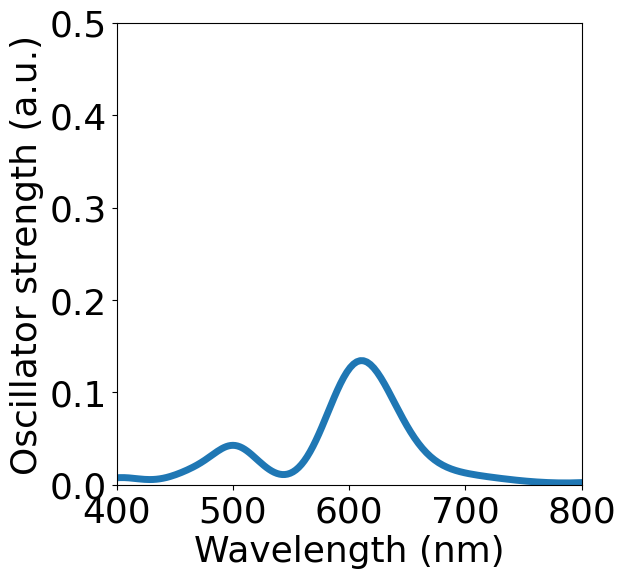

(0.0, 0.5)

In [294]:
eigenvalsup = np.fromfile("$dir_nohybrid/STH2$(41).eigenvals")[1:48]*eV
eigenvalsdn = np.fromfile("$dir_nohybrid/STH2$(41).eigenvals")[49:96]*eV
FSTH2=zeros(100*30)
energies = collect(range(0, 30, length=3000))
lambdas = 1240 ./ collect(range(1, 30, length=3000))
broadening=0.1
for (e1iter, e2iter) in Tuple.(CartesianIndices(rand(48, 48))) 
    eigup2 = eigenvalsup[e2iter]
    eigup1 = eigenvalsup[e1iter]
    eigdn2 = eigenvalsdn[e2iter]
    eigdn1 = eigenvalsdn[e1iter]
    ediffup = (eigup2-eigup1)
    ediffdn = (eigdn2-eigdn1)
    momentaup_squared = sum((abs.(momenta[1, :, e1iter, e2iter])).^2)
    momentadn_squared = sum((abs.(momenta[2, :, e1iter, e2iter])).^2)
    f = (1-np.heaviside(μ*eV-eigup2, 0.5))*(np.heaviside(μ*eV-eigup1, 0.5))
    !(f ≈ 0) && (f *= 2/3*(1/ediffup)*(momentaup_squared))
    FSTH2 += f*exp.(-0.5*(energies.-ediffup).^2/(broadening)^2)
    f = (1-np.heaviside(μ*eV-eigdn2, 0.5))*(np.heaviside(μ*eV-eigdn1, 0.5))
    !(f ≈ 0) && (f *= 2/3*(1/ediffdn)*(momentadn_squared))
    FSTH2 += f*exp.(-0.5*(energies.-ediffdn).^2/(broadening)^2)
end

FSTH2 *= eV
plot(lambdas, FSTH2, linewidth=5)
ylabel("Oscillator strength (a.u.)")
xlabel("Wavelength (nm)")
xlim(400,800)
ylim(0, 0.5)


In [296]:
Pairsup_green = Vector{Tuple{Integer, Integer, Float64}}()
Pairsdn_green = Vector{Tuple{Integer, Integer, Float64}}()

Pairsup_red = Vector{Tuple{Integer, Integer, Float64}}()
Pairsdn_red = Vector{Tuple{Integer, Integer, Float64}}()

for e1iter in 10:16
    for e2iter in 10:28
        (e2iter == e1iter) && continue
        eigup2 = eigenvalsup[e2iter]
        eigup1 = eigenvalsup[e1iter]
        eigdn2 = eigenvalsdn[e2iter]
        eigdn1 = eigenvalsdn[e1iter]
        ediffup = (eigup2-eigup1)
        ediffdn = (eigdn2-eigdn1)
        momentaup_squared = sum((abs.(momenta[1, :, e1iter, e2iter])).^2)
        momentadn_squared = sum((abs.(momenta[2, :, e1iter, e2iter])).^2)
        f = 2/3*(1/ediffup)*(momentaup_squared)
        (isless(1.7, ediffup) &&  isless(ediffup, 1.9)) && push!(Pairsup_red, (e1iter, e2iter, f))
        (isless(2.1, ediffup) &&  isless(ediffup, 2.3)) && push!(Pairsup_green, (e1iter, e2iter, f))
        f = 2/3*(1/ediffdn)*(momentadn_squared)
        (isless(1.7, ediffdn) &&  isless(ediffup, 1.9)) && push!(Pairsdn_red, (e1iter, e2iter, f))
        (isless(2.1, ediffdn) &&  isless(ediffup, 2.3)) && push!(Pairsdn_green, (e1iter, e2iter, f))
    end
end


In [297]:
pairsup_red_max_idx = argmax([p[3] for p in Pairsup_red])
pairsdn_red_max_idx = argmax([p[3] for p in Pairsdn_red])
pairsup_green_max_idx = argmax([p[3] for p in Pairsup_green])
pairsdn_green_max_idx = argmax([p[3] for p in Pairsdn_green])

3

In [298]:
Pairsup_red[pairsup_red_max_idx]

(11, 17, 0.002832311160177203)

In [299]:
Pairsdn_red[pairsdn_red_max_idx]

(11, 17, 0.002092524537558207)

In [300]:
Pairsup_green[pairsup_green_max_idx]

(10, 18, 0.0009202953705559318)

In [301]:
Pairsdn_green[pairsdn_green_max_idx]

(14, 23, 0.0009489456353023339)

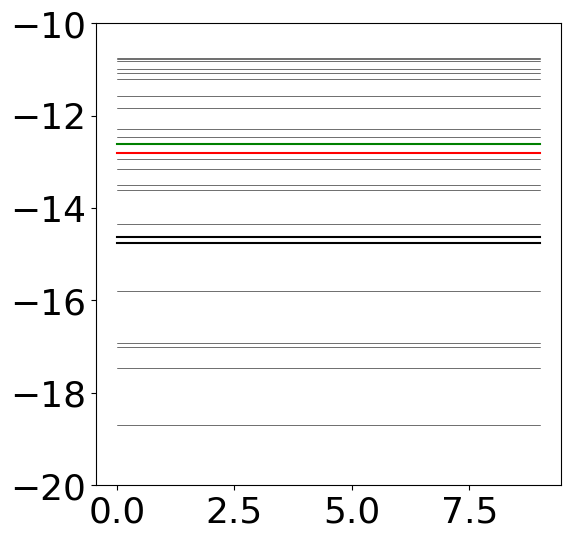

(-20.0, -10.0)

In [302]:
plot(np.repeat(eigenvalsup[11], 10), color="black")
plot(np.repeat(eigenvalsup[17], 10), color="red")
plot(np.repeat(eigenvalsup[10], 10), color="black")
plot(np.repeat(eigenvalsup[18], 10), color="green")
for i in 1:48
    i == 11 && continue
    i == 17 && continue
    i == 10 && continue
    i == 18 && continue
    plot(np.repeat(eigenvalsup[i], 10), color="black", linewidth=0.4)
end
ylim(-20, -10)